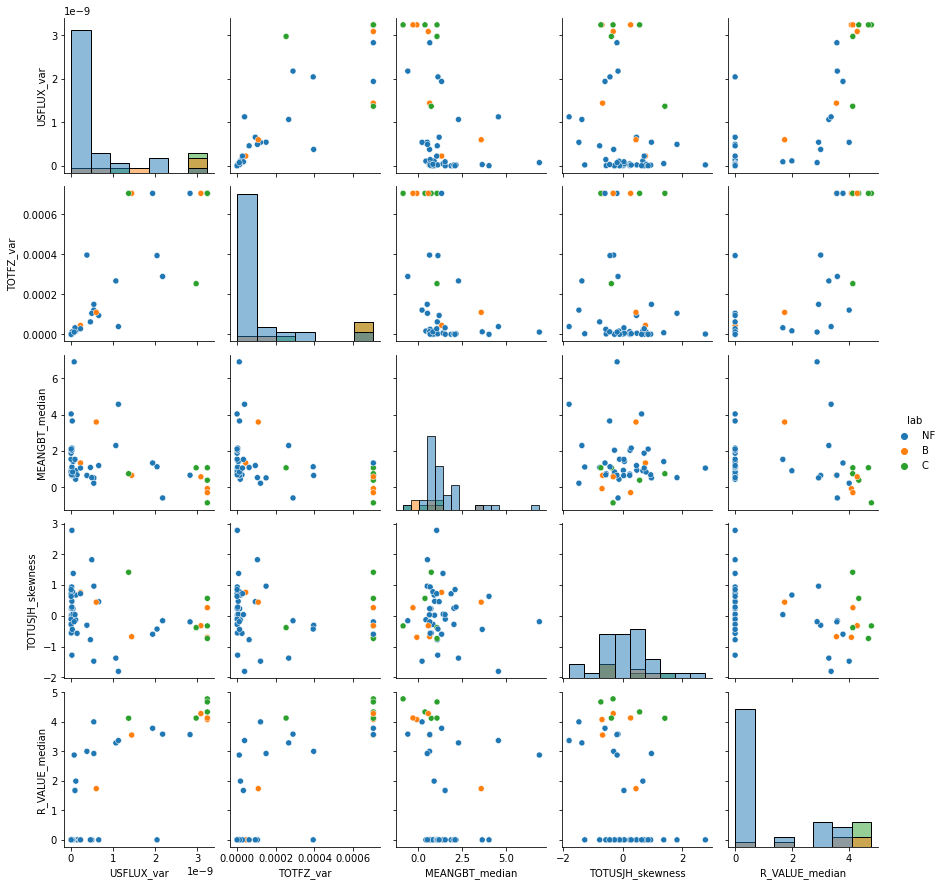

In [1]:
%matplotlib inline
import os
import math
from typing import List
import pandas as pd
from pandas import DataFrame 
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

data_dir = 'partition1'
summary_table_name = 'data_quality_table.csv'
data_file = 'toy_cleaned_partition1ExtractedFeatures.csv'

abt = pd.read_csv(os.path.join(data_dir, data_file))
summary_table = pd.read_csv(os.path.join(data_dir, summary_table_name))

def get_features_with_large_range(summary_table:DataFrame) -> List[str]:
    outputList = []
    for i in range(len(summary_table)):
        rangeMinMax = summary_table.iloc[i]['Max'] - summary_table.iloc[i]['Min']
        outlierCount = summary_table.iloc[i]['Outlier Count Low'] + summary_table.iloc[i]['Outlier Count High']       
        
        if rangeMinMax > 10000 and outlierCount > 0.10 * summary_table.iloc[i]['Non-null Count']:
            outputList.append(summary_table.iloc[i]['Feature Name'])
            
    return outputList

listOfFeatures = get_features_with_large_range(summary_table)

def clamp_to_third_quartile(data:DataFrame) -> None:
    for i in range(len(data.columns)):
        thirdQuart = np.percentile(data.iloc[:,i], 75)
        firstQuart = np.percentile(data.iloc[:,i], 25)
        IQR = thirdQuart - firstQuart
        outlierHigh = thirdQuart + 1.5 * IQR
        data.iloc[:,i].clip(0, outlierHigh, inplace=True)

features_to_look_at = ['USFLUX_var','TOTUSJH_var','TOTFZ_var']

features = abt.filter([features_to_look_at[0],features_to_look_at[1],features_to_look_at[2]], axis=1)

def clip_upper_and_decimal_scale(data:DataFrame, feature_name:str) -> DataFrame:
    df = pd.DataFrame(data[feature_name])
    clamp_to_third_quartile(df)
    for i in range(len(df)):
        df.iloc[i] = df.iloc[i] / 10 ** len(df)
    return df

usDF = clip_upper_and_decimal_scale(abt, 'USFLUX_var')
totDF = clip_upper_and_decimal_scale(abt, 'TOTFZ_var')
labs = abt['lab']
cleanedFeatureTable = pd.concat([labs, usDF, totDF], axis=1)

def get_features_with_smaller_range(summary_table:DataFrame) -> List[str]:
    outputList = []
    for i in range(len(summary_table)):
        rangeMinMax = summary_table.iloc[i]['Max'] - summary_table.iloc[i]['Min']
        outlierCount = summary_table.iloc[i]['Outlier Count Low'] + summary_table.iloc[i]['Outlier Count High']       
        
        if rangeMinMax < 10000 and outlierCount < 0.05 * summary_table.iloc[i]['Non-null Count']:
            outputList.append(summary_table.iloc[i]['Feature Name'])
            
    return outputList

get_features_with_smaller_range(summary_table)

small_outlier_features = ['R_VALUE_median', 'MEANGBT_median', 'TOTUSJH_skewness']
newFeatures = abt.filter([small_outlier_features[0],small_outlier_features[1],small_outlier_features[2]], axis=1)

def do_z_score_normalization(data:DataFrame, feature_name:str) -> DataFrame:
    df = pd.DataFrame(data[feature_name])
    for i in range(len(df)):
        df.iloc[i] = (df.iloc[i] - df.mean()) / df.std()
    return df

meanDF = do_z_score_normalization(abt, 'MEANGBT_median')
totJHDF = do_z_score_normalization(abt, 'TOTUSJH_skewness')
cleanedFeatureTable = pd.concat([cleanedFeatureTable, meanDF, totJHDF, newFeatures['R_VALUE_median']], axis=1)


sns.pairplot(cleanedFeatureTable, hue='lab', diag_kind='hist')